# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [6]:
!pip install labelme tensorflow opencv-python matplotlib albumentations

### 1.2 Collect Images Using OpenCV

In [1]:
import os
import time
import uuid
import cv2

In [3]:
IMAGES_PATH = os.path.join('images')
number_images = 30

In [5]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(1)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [8]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\BG\.labelmerc


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [2]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0']


In [4]:
gpus

[]

In [12]:
tf.config.list_physical_devices('GPU')

[]

### 2.3 Load Image into TF Data Pipeline

In [6]:
images = tf.data.Dataset.list_files('images\\*.jpg')

In [7]:
images.as_numpy_iterator().next()

b'images\\0d4455da-3d45-11ee-be4b-c025a53d69a1.jpg'

In [3]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [9]:
images = images.map(load_image)

In [10]:
images.as_numpy_iterator().next()

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [199, 198, 206],
        [199, 197, 208],
        [199, 197, 208]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [199, 198, 206],
        [199, 197, 208],
        [199, 197, 208]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [199, 198, 206],
        [199, 197, 208],
        [199, 197, 208]],

       ...,

       [[206, 206, 214],
        [203, 206, 213],
        [203, 206, 211],
        ...,
        [169, 163, 165],
        [168, 162, 164],
        [171, 165, 167]],

       [[205, 208, 215],
        [204, 207, 214],
        [203, 206, 211],
        ...,
        [167, 161, 163],
        [167, 158, 161],
        [170, 161, 164]],

       [[206, 209, 216],
        [205, 208, 215],
        [202, 207, 211],
        ...,
        [165, 159, 161],
        [164, 155, 158],
        [167, 158, 161]]

In [11]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [12]:
image_generator = images.batch(4).as_numpy_iterator()

In [13]:
plot_images = image_generator.next()

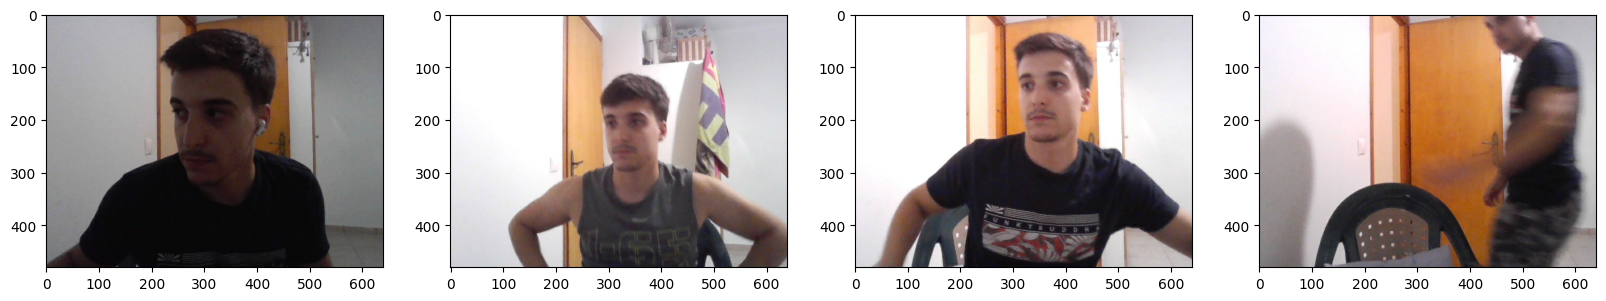

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [ ]:
90*.7 # 63 to train

In [ ]:
90*.15 # 14 and 13 to test and val

### 3.2 Move the Matching Labels

In [19]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join(folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join(folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [20]:
import albumentations as alb

In [21]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [25]:
img = cv2.imread(os.path.join('train', 'images','0b21c426-3d45-11ee-9534-c025a53d69a1.jpg'))

In [26]:
with open(os.path.join('train', 'labels', '0b21c426-3d45-11ee-9534-c025a53d69a1.json'), 'r') as f:
    label = json.load(f)

In [27]:
label['shapes'][0]['points']

[[51.31313131313132, 149.0909090909091],
 [220.00000000000003, 332.4242424242424]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [28]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [29]:
coords

[51.31313131313132, 149.0909090909091, 220.00000000000003, 332.4242424242424]

In [30]:
coords = list(np.divide(coords, [640,480,640,480]))

In [31]:
coords

[0.0801767676767677,
 0.3106060606060606,
 0.34375000000000006,
 0.692550505050505]

### 4.4 Apply Augmentations and View Results

In [32]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [33]:
augmented['bboxes'][0][2:]

(1.0, 0.6797979797979798)

In [34]:
augmented['bboxes']

[(0.8866666666666666, 0.2723905723905725, 1.0, 0.6797979797979798)]

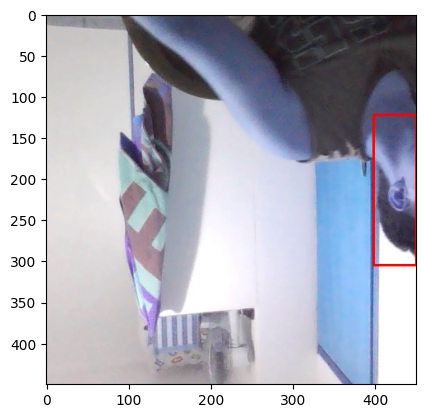

In [35]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [39]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join(partition, 'images')):
        img = cv2.imread(os.path.join(partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join(partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(100):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

y_max is less than or equal to y_min for bbox [0.2703598484848485, 0.7314814814814814, 0.578125, 0.23379629629629628, 'face'].
y_max is less than or equal to y_min for bbox [0.28929924242424243, 0.7283249158249158, 0.5797032828282829, 0.2537878787878788, 'face'].
y_max is less than or equal to y_min for bbox [0.408459595959596, 0.6125841750841751, 0.6104797979797979, 0.2401094276094276, 'face'].
y_max is less than or equal to y_min for bbox [0.4400252525252526, 0.6104797979797979, 0.6238952020202021, 0.23695286195286194, 'face'].
y_max is less than or equal to y_min for bbox [0.4305555555555555, 0.6420454545454546, 0.6309974747474747, 0.24116161616161616, 'face'].
y_max is less than or equal to y_min for bbox [0.4305555555555555, 0.6452020202020202, 0.642834595959596, 0.2359006734006734, 'face'].
y_max is less than or equal to y_min for bbox [0.3390151515151515, 0.6936026936026936, 0.6972853535353535, 0.06334175084175084, 'face'].
y_max is less than or equal to y_min for bbox [0.407670

### 5.2 Load Augmented Images to Tensorflow Dataset

In [4]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [5]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [6]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [7]:
train_images.as_numpy_iterator().next()

array([[[0.3127451 , 0.2367647 , 0.21023284],
        [0.30245098, 0.21862745, 0.20441176],
        [0.28903186, 0.20667893, 0.19197305],
        ...,
        [0.8093137 , 0.8093137 , 0.8485294 ],
        [0.8127451 , 0.8093137 , 0.841299  ],
        [0.8132353 , 0.8126838 , 0.841299  ]],

       [[0.32156864, 0.23137255, 0.20686275],
        [0.31139705, 0.22120099, 0.19669117],
        [0.28106618, 0.20949756, 0.17077206],
        ...,
        [0.8117647 , 0.8235294 , 0.85784316],
        [0.8156863 , 0.81911767, 0.8401961 ],
        [0.81697303, 0.81832105, 0.8392157 ]],

       [[0.32806373, 0.23002452, 0.20257352],
        [0.33137256, 0.23431373, 0.20637254],
        [0.3033701 , 0.2245098 , 0.18921569],
        ...,
        [0.80735296, 0.81911767, 0.84656864],
        [0.8004289 , 0.81219363, 0.8318015 ],
        [0.8143995 , 0.81832105, 0.8340074 ]],

       ...,

       [[0.63933825, 0.6175858 , 0.63327205],
        [0.6317402 , 0.6240196 , 0.6365809 ],
        [0.6177083 , 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [8]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [9]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [10]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [11]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [12]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2322, 0.2766, 0.671 , 0.8164], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [13]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3400, 3400, 900, 900, 800, 800)

### 7.2 Create Final Datasets (Images/Labels)

In [14]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [15]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [16]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [25]:
# Save datasets
tf.data.Dataset.save(train, "train_dset")
tf.data.Dataset.save(test, "test_dset")
tf.data.Dataset.save(val, "val_dset")

In [17]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.225  , 0.1849 , 0.4875 , 0.5776 ],
        [0.     , 0.278  , 0.3445 , 0.6855 ],
        [0.2063 , 0.01859, 0.6934 , 0.69   ],
        [0.04843, 0.     , 0.3772 , 0.4275 ],
        [0.242  , 0.2489 , 0.773  , 0.9995 ],
        [0.4048 , 0.     , 0.846  , 0.4014 ],
        [0.     , 0.2744 , 0.4822 , 1.     ],
        [0.1699 , 0.2461 , 0.5103 , 0.658  ]], dtype=float16))

### 7.3 View Images and Annotations

In [54]:
data_samples = train.as_numpy_iterator()

In [55]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


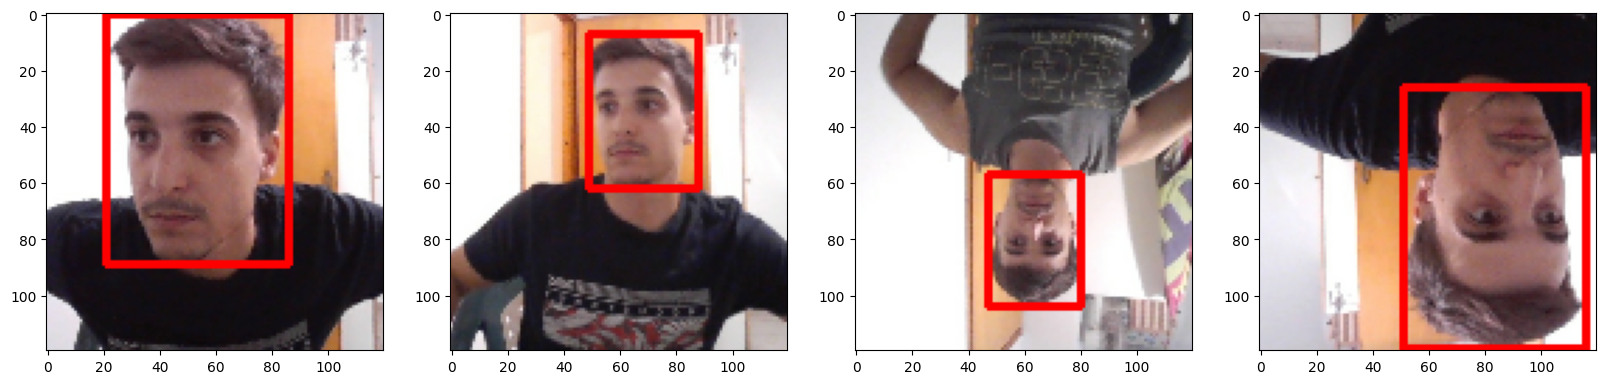

In [56]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [27]:
vgg = VGG16(include_top=False)

In [28]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [29]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [30]:
facetracker = build_model()

In [31]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [32]:
X, y = train.as_numpy_iterator().next()

In [33]:
X.shape

(8, 120, 120, 3)

In [34]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 582ms/step


In [35]:
classes, coords

(array([[0.4598482 ],
        [0.41743526],
        [0.4760679 ],
        [0.53357595],
        [0.39823124],
        [0.4582937 ],
        [0.46567288],
        [0.45352253]], dtype=float32),
 array([[0.34200683, 0.45222995, 0.49718678, 0.64164156],
        [0.4127188 , 0.4527544 , 0.45541728, 0.7298192 ],
        [0.47600448, 0.57647955, 0.48199257, 0.5593795 ],
        [0.45154226, 0.4130965 , 0.56796634, 0.6080222 ],
        [0.3786333 , 0.5130697 , 0.3648692 , 0.62417644],
        [0.4025239 , 0.48586106, 0.49246684, 0.6103152 ],
        [0.5580453 , 0.50793403, 0.48282674, 0.6795824 ],
        [0.44273445, 0.4565922 , 0.50708205, 0.63377166]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [36]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [37]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

### 9.2 Create Localization Loss and Classification Loss

In [38]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [39]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [40]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.9396167>

In [41]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7845977>

In [42]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.9396167>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [43]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [44]:
model = FaceTracker(facetracker)

In [45]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [46]:
logdir='logs'

In [47]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [48]:
hist = model.fit(train, epochs=12, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/12


425/425 [==============================] - 524s 1s/step - total_loss: 0.2858 - class_loss: 0.0583 - regress_loss: 0.2567 - val_total_loss: 0.0556 - val_class_loss: 6.9281e-05 - val_regress_loss: 0.0556
Epoch 2/12
425/425 [==============================] - 513s 1s/step - total_loss: 0.0235 - class_loss: 1.5807e-04 - regress_loss: 0.0235 - val_total_loss: 0.0527 - val_class_loss: 4.2023e-05 - val_regress_loss: 0.0527
Epoch 3/12
425/425 [==============================] - 515s 1s/step - total_loss: 0.0128 - class_loss: 4.8917e-05 - regress_loss: 0.0128 - val_total_loss: 0.0255 - val_class_loss: 3.3804e-05 - val_regress_loss: 0.0255
Epoch 4/12
425/425 [==============================] - 512s 1s/step - total_loss: 0.1357 - class_loss: 0.0428 - regress_loss: 0.1143 - val_total_loss: 0.6367 - val_class_loss: 0.1416 - val_regress_loss: 0.5659
Epoch 5/12
425/425 [==============================] - 519s 1s/step - total_loss: 0.3998 - class_loss: 0.0907 - regress_loss: 0.3544 - val_total_loss: 0.172

### 10.3 Plot Performance

In [49]:
hist.history

{'total_loss': [0.02076764591038227,
  0.017209945246577263,
  0.016597958281636238,
  1.5149332284927368,
  0.02361057698726654,
  0.01194566860795021,
  0.007297138217836618,
  0.007599597331136465,
  0.007708050776273012,
  0.012643977999687195,
  0.010929950512945652,
  0.012404927052557468],
 'class_loss': [0.00040701651596464217,
  0.00012337774387560785,
  5.7324275985592976e-05,
  0.16996833682060242,
  0.001000341959297657,
  0.00011408978753024712,
  1.6764293832238764e-05,
  2.312724791408982e-05,
  2.27325945161283e-05,
  1.3806269635097124e-05,
  3.7093432183610275e-05,
  4.485291810851777e-06],
 'regress_loss': [0.020564137026667595,
  0.017148256301879883,
  0.016569295898079872,
  1.4299490451812744,
  0.023110406473279,
  0.011888624168932438,
  0.007288755849003792,
  0.007588033564388752,
  0.0076966844499111176,
  0.012637075036764145,
  0.01091140415519476,
  0.012402684427797794],
 'val_total_loss': [0.05560151860117912,
  0.05271071568131447,
  0.0254861433058977

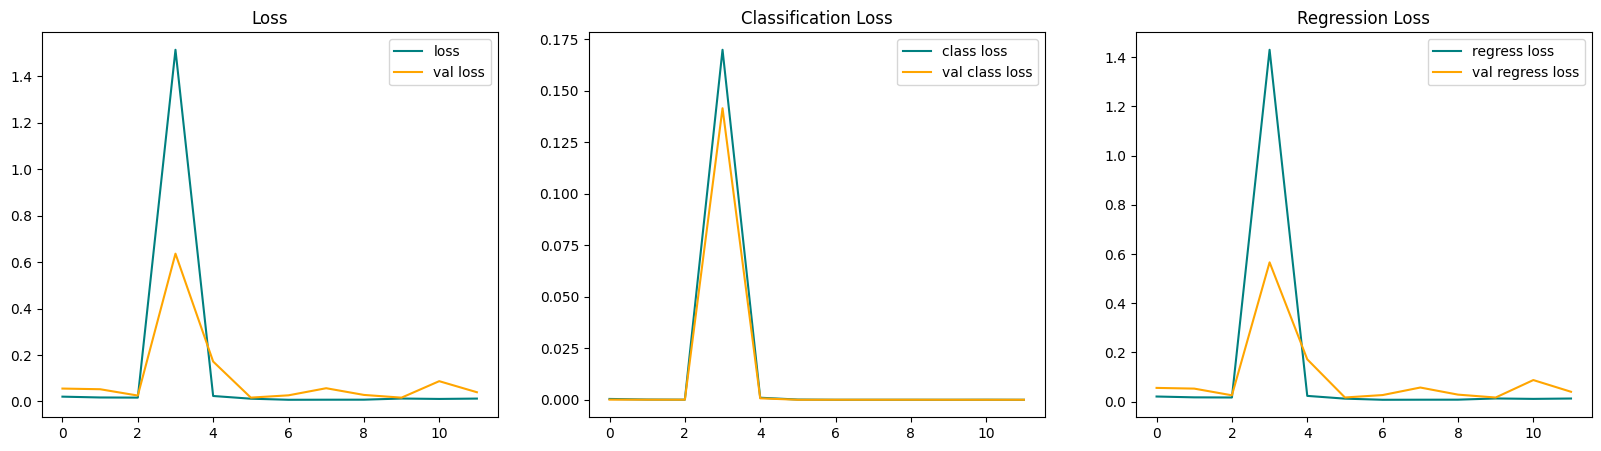

In [50]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [51]:
test_data = test.as_numpy_iterator()

In [52]:
test_sample = test_data.next()

In [53]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 223ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


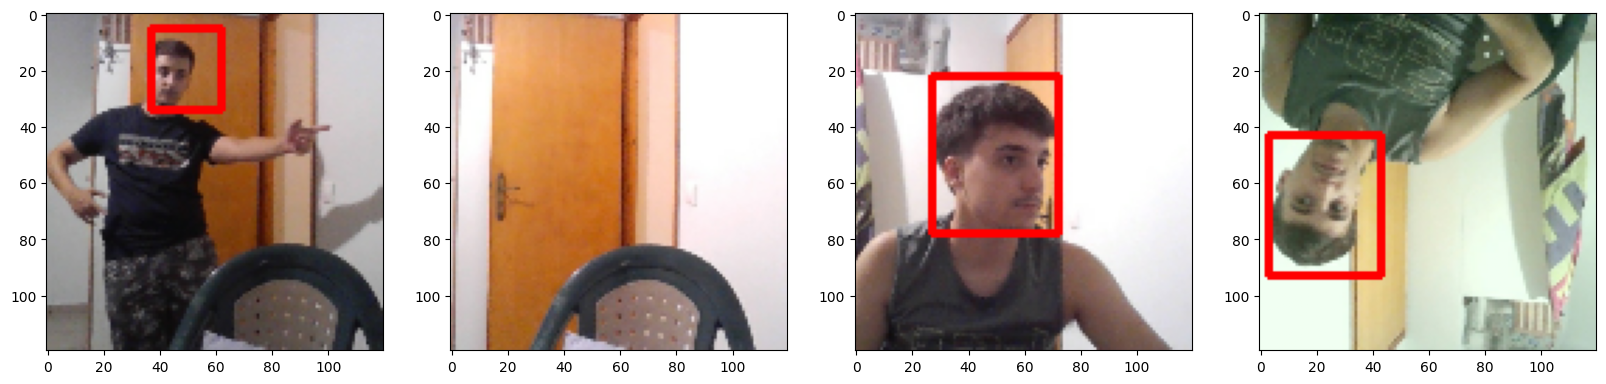

In [54]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [3]:
from tensorflow.keras.models import load_model

In [56]:
facetracker.save('facetracker.h5')

C:\Users\BG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [4]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [5]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 52ms/step


In [11]:
cap.release()
cv2.destroyAllWindows()